# Goals

1. Load data from SQLlite data base
2. Join metabolomics measurements and clinical metadata tables
3. Run PCA
4. Generate plot scores plot and color by ICU status

## 1. Load data from SQLlite data base

In [5]:
# Import create_engine
from sqlalchemy import create_engine, MetaData, Table, select, join

# SQLite path
db_path = 'sqlite:///../../../data/SQLite Database/Covid-19 Study DB.sqlite'

# Create an engine that connects to the Covid-19 Study DB.sqlite file: engine
engine = create_engine(db_path)

# Establish connection
connection = engine.connect()

# Print table names
print(engine.table_names())

['biomolecules', 'deidentified_patient_metadata', 'lipidomics_measurements', 'lipidomics_runs', 'metabolomics_measurements', 'metabolomics_runs', 'metadata', 'omes', 'patient_metadata', 'patient_samples', 'proteomics_measurements', 'proteomics_runs', 'rawfiles', 'sqlite_sequence']


In [6]:
# Instantiate metadata table
metadata = MetaData()

# Reflect the metabolomics_measurements table from the engine: metabolomics_measurements
metabolomics_measurements = Table('metabolomics_measurements', metadata, autoload=True, autoload_with=engine)

# Print the column names
print(metabolomics_measurements.columns.keys())

['measurement_id', 'replicate_id', 'biomolecule_id', 'raw_abundance', 'normalized_abundance']


In [7]:
# Reflect the metabolomics_runs table from the engine: metabolomics_runs
metabolomics_runs = Table('metabolomics_runs', metadata, autoload=True, autoload_with=engine)

# Print the column names
print(metabolomics_runs.columns.keys())

['replicate_id', 'rawfile_id', 'unique_identifier']


In [8]:
# Reflect the rawfiles table from the engine: cerawfilesnsus
rawfiles = Table('rawfiles', metadata, autoload=True, autoload_with=engine)

# Print the column names
print(rawfiles.columns.keys())

['rawfile_id', 'timestamp', 'rawfile_name', 'sample_id', 'run_type', 'keep', 'batch', 'ome_id']


In [9]:
# Reflect the metabolomics_runs table from the engine: metabolomics_runs
deidentified_patient_metadata = Table('deidentified_patient_metadata', metadata, autoload=True, autoload_with=engine)

# Print the column names
print(deidentified_patient_metadata.columns.keys())

['sample_id', 'Sample_label', 'Albany_sampleID', 'COVID', 'Hospital_free_days', 'Age_less_than_90', 'Gender', 'ICU_1', 'APACHEII', 'Charlson_score', 'Mech_Ventilation', 'Vent_free_days']


## 2. Join metabolomics measurements and clinical metadata tables

Metabolomics measurements can be connected to patient meta via multiple join

1. metabolomics_measurements['replicate_id'] -> metabolomics_runs['replicate_id']
2. metabolomics_runs['rawfile_id'] -> rawfiles['rawfile_id']
3. rawfiles['sample_id'] -> deidentified_patient_metadata['sample_id']
4. deidentified_patient_metadata[['COVID', 'ICU_1', Mech_Ventilation']]

In [85]:
# https://www.tutorialspoint.com/sqlalchemy/sqlalchemy_core_using_joins.htm
from sqlalchemy import join
from sqlalchemy.sql import select

j = metabolomics_measurements.join(metabolomics_runs, metabolomics_measurements.c.replicate_id == metabolomics_runs.c.replicate_id)\
    .join(rawfiles, metabolomics_runs.c.rawfile_id==rawfiles.c.rawfile_id)\
    .join(deidentified_patient_metadata, rawfiles.c.sample_id==deidentified_patient_metadata.c.sample_id)

stmt = select([metabolomics_measurements, deidentified_patient_metadata]).select_from(j)
result = connection.execute(stmt)
result.fetchmany(size=10)

[(21716, 121, 1, 20.74501332, 21.3098966372068, '1', 'COVID_01', 'C1', '1', '0', '39', 'M', '0', '15', '0', '1', '0'),
 (21717, 121, 2, 21.70633334, 21.7833078310619, '1', 'COVID_01', 'C1', '1', '0', '39', 'M', '0', '15', '0', '1', '0'),
 (21718, 121, 3, 22.57034767, 22.6870914559704, '1', 'COVID_01', 'C1', '1', '0', '39', 'M', '0', '15', '0', '1', '0'),
 (21719, 121, 4, 25.14983841, 25.1799142989264, '1', 'COVID_01', 'C1', '1', '0', '39', 'M', '0', '15', '0', '1', '0'),
 (21720, 121, 5, 21.67189183, 21.6309204409134, '1', 'COVID_01', 'C1', '1', '0', '39', 'M', '0', '15', '0', '1', '0'),
 (21721, 121, 6, 22.55288388, 22.5259871151933, '1', 'COVID_01', 'C1', '1', '0', '39', 'M', '0', '15', '0', '1', '0'),
 (21722, 121, 7, 10.02842216, 10.4538758470883, '1', 'COVID_01', 'C1', '1', '0', '39', 'M', '0', '15', '0', '1', '0'),
 (21723, 121, 8, 11.90219889, 13.4019767784001, '1', 'COVID_01', 'C1', '1', '0', '39', 'M', '0', '15', '0', '1', '0'),
 (21724, 121, 9, 12.01436182, 11.7354863713926, 

In [86]:
# show the full SQL statement
print(stmt)

SELECT metabolomics_measurements.measurement_id, metabolomics_measurements.replicate_id, metabolomics_measurements.biomolecule_id, metabolomics_measurements.raw_abundance, metabolomics_measurements.normalized_abundance, deidentified_patient_metadata.sample_id, deidentified_patient_metadata."Sample_label", deidentified_patient_metadata."Albany_sampleID", deidentified_patient_metadata."COVID", deidentified_patient_metadata."Hospital_free_days", deidentified_patient_metadata."Age_less_than_90", deidentified_patient_metadata."Gender", deidentified_patient_metadata."ICU_1", deidentified_patient_metadata."APACHEII", deidentified_patient_metadata."Charlson_score", deidentified_patient_metadata."Mech_Ventilation", deidentified_patient_metadata."Vent_free_days" 
FROM metabolomics_measurements JOIN metabolomics_runs ON metabolomics_measurements.replicate_id = metabolomics_runs.replicate_id JOIN rawfiles ON metabolomics_runs.rawfile_id = rawfiles.rawfile_id JOIN deidentified_patient_metadata ON r

In [87]:
print(metabolomics_measurements.columns.keys() + deidentified_patient_metadata.columns.keys())

['measurement_id', 'replicate_id', 'biomolecule_id', 'raw_abundance', 'normalized_abundance', 'sample_id', 'Sample_label', 'Albany_sampleID', 'COVID', 'Hospital_free_days', 'Age_less_than_90', 'Gender', 'ICU_1', 'APACHEII', 'Charlson_score', 'Mech_Ventilation', 'Vent_free_days']


In [88]:
import pandas as pd

joined_df = pd.DataFrame(result.fetchall())
joined_df.columns = metabolomics_measurements.columns.keys() + deidentified_patient_metadata.columns.keys()
joined_df.head()

,measurement_id,replicate_id,biomolecule_id,raw_abundance,normalized_abundance,sample_id,Sample_label,Albany_sampleID,COVID,Hospital_free_days,Age_less_than_90,Gender,ICU_1,APACHEII,Charlson_score,Mech_Ventilation,Vent_free_days
0,21726,121,11,13.142800,16.262668,1,COVID_01,C1,1,0,39,M,0,15,0,1,0
1,21727,121,12,21.259488,21.240711,1,COVID_01,C1,1,0,39,M,0,15,0,1,0
2,21728,121,13,12.813945,12.888080,1,COVID_01,C1,1,0,39,M,0,15,0,1,0
3,21729,121,14,12.770113,12.736195,1,COVID_01,C1,1,0,39,M,0,15,0,1,0
4,21730,121,15,12.650865,12.642085,1,COVID_01,C1,1,0,39,M,0,15,0,1,0


In [89]:
joined_df.shape

(31380, 17)

In [90]:
joined_df.drop_duplicates().shape

(31380, 17)

In [91]:
wide_df = joined_df.pivot_table(index='sample_id', columns='biomolecule_id', values='normalized_abundance')
wide_df.head()

biomolecule_id,1,2,3,4,5,6,7,8,9,10,...,206,207,208,209,210,211,212,213,214,215
sample_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.735665,13.040251,12.276960,12.688793,17.169812,17.874240,12.808183,12.773660,15.037276,15.037276
10,20.625906,21.873159,23.564427,27.688025,16.610075,22.634601,12.231073,14.160800,13.309080,23.895285,...,13.519018,13.388211,13.478136,20.504155,17.512638,15.204200,13.812129,13.804686,17.166528,17.166528
100,20.662917,22.549653,22.840298,26.082512,20.761355,22.129562,13.516431,17.911787,13.108486,15.764481,...,13.530966,13.537485,13.344140,13.788838,14.006516,17.436237,14.091067,13.730729,17.113001,17.113001
101,22.360212,21.846840,23.050276,26.990202,18.928471,21.942203,13.364934,13.401198,13.029064,13.519000,...,12.858362,13.017871,11.943209,13.132328,12.695043,16.700752,13.280378,12.620021,18.143107,18.143107
102,21.813873,21.989365,24.234489,28.192456,16.838486,21.875789,12.155274,17.781388,13.581510,13.555614,...,11.881474,13.621948,13.704429,12.247701,17.927238,16.414562,13.065931,12.379498,16.111023,16.111023


In [92]:
joined_df.pivot_table(index='sample_id', columns='biomolecule_id', values='normalized_abundance').isna().sum().sum()

10

In [93]:
joined_df[joined_df['sample_id']=='3'].describe()

,measurement_id,replicate_id,biomolecule_id,raw_abundance,normalized_abundance
count,215.000000,215.0,215.000000,215.000000,215.000000
mean,38163.000000,221.0,108.000000,17.406535,17.598325
std,62.209324,0.0,62.209324,3.998175,3.990891
min,38056.000000,221.0,1.000000,11.949517,11.755886
25%,38109.500000,221.0,54.500000,13.164293,13.734355
50%,38163.000000,221.0,108.000000,17.444954,17.536684
75%,38216.500000,221.0,161.500000,20.160013,20.443621
max,38270.000000,221.0,215.000000,28.445077,28.766705


In [19]:
wide_df.dropna()

biomolecule_id,1,2,3,4,5,6,7,8,9,10,...,206,207,208,209,210,211,212,213,214,215
sample_id,,,,,,,,,,,,,,,,,,,,,
10,20.625906,21.873159,23.564427,27.688025,16.610075,22.634601,12.231073,14.160800,13.309080,23.895285,...,13.519018,13.388211,13.478136,20.504155,17.512638,15.204200,13.812129,13.804686,17.166528,17.166528
100,20.662917,22.549653,22.840298,26.082512,20.761355,22.129562,13.516431,17.911787,13.108486,15.764481,...,13.530966,13.537485,13.344140,13.788838,14.006516,17.436237,14.091067,13.730729,17.113001,17.113001
101,22.360212,21.846840,23.050276,26.990202,18.928471,21.942203,13.364934,13.401198,13.029064,13.519000,...,12.858362,13.017871,11.943209,13.132328,12.695043,16.700752,13.280378,12.620021,18.143107,18.143107
102,21.813873,21.989365,24.234489,28.192456,16.838486,21.875789,12.155274,17.781388,13.581510,13.555614,...,11.881474,13.621948,13.704429,12.247701,17.927238,16.414562,13.065931,12.379498,16.111023,16.111023
103,21.923397,21.740432,22.852894,25.741902,17.267050,21.375991,12.467264,13.691479,12.633755,12.707312,...,12.539112,12.888349,12.959471,13.089788,14.869794,16.710962,13.741838,12.613334,13.451596,13.451596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,20.792265,21.711325,22.881555,25.406746,18.488325,24.077752,13.021569,14.025023,12.598229,15.929856,...,13.129927,12.967827,12.522604,12.612814,18.002319,16.685760,13.718468,12.695960,15.104294,15.104294
96,23.134671,21.810881,23.192704,26.760238,12.664495,21.575231,11.516891,17.768753,12.810127,13.388827,...,12.728948,13.146975,12.589521,12.670543,20.546220,16.414667,13.347771,11.033808,17.419396,17.419396
97,21.939655,21.270367,23.387662,27.649908,21.495076,21.476968,12.540594,18.217819,13.291450,14.018969,...,13.073348,13.056241,13.376785,13.397164,19.281831,16.654429,13.344848,12.101831,16.104166,16.104166


## 3. Run PCA

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
PCA = pca.fit_transform(wide_df.dropna()) # drop first sample with missing values

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

PC1s = []
PC2s = []
for PCs in PCA:
    PC1 = PCs[0]
    PC2 = PCs[1]
    PC1s.append(PC1)
    PC2s.append(PC2)

#colormap = {'subject1': 'red', 'subject2': 'blue'}
#colors = [colormap[x] for x in sample_labels]

[0.80730823 0.03501811 0.02746934 0.0143676  0.01197397 0.00857376
 0.00711822 0.00588702 0.00413274 0.00400644]
0.9258554464044985


Get metadata for color and shape scheme

In [59]:
deidentified_patient_metadata_df = joined_df[deidentified_patient_metadata.columns.keys()].drop_duplicates().set_index('sample_id')
deidentified_patient_metadata_df.head()

,Sample_label,Albany_sampleID,COVID,Hospital_free_days,Age_less_than_90,Gender,ICU_1,APACHEII,Charlson_score,Mech_Ventilation,Vent_free_days
sample_id,,,,,,,,,,,
1,COVID_01,C1,1,0,39,M,0,15,0,1,0
2,COVID_02,C2,1,22,63,M,0,,2,0,28
3,COVID_03,C3,1,1,33,M,0,,2,0,28
4,COVID_04,C4,1,22,49,M,0,,1,0,28
5,COVID_05,C5,1,10,49,M,0,19,1,1,23


In [104]:
deidentified_patient_metadata_df.loc['54']

Sample_label          COVID_54
Albany_sampleID               
COVID                         
Hospital_free_days            
Age_less_than_90              
Gender                        
ICU_1                         
APACHEII                      
Charlson_score                
Mech_Ventilation              
Vent_free_days                
Name: 54, dtype: object

In [62]:
# combine quant values with clinical metadata 
combined_df = wide_df.join(deidentified_patient_metadata_df).dropna()
combined_df

,1,2,3,4,5,6,7,8,9,10,...,Albany_sampleID,COVID,Hospital_free_days,Age_less_than_90,Gender,ICU_1,APACHEII,Charlson_score,Mech_Ventilation,Vent_free_days
sample_id,,,,,,,,,,,,,,,,,,,,,
10,20.625906,21.873159,23.564427,27.688025,16.610075,22.634601,12.231073,14.160800,13.309080,23.895285,...,C10,1,0,62,M,1,34,1,1,2
100,20.662917,22.549653,22.840298,26.082512,20.761355,22.129562,13.516431,17.911787,13.108486,15.764481,...,C100,1,NA,74,F,0,,6,0,28
101,22.360212,21.846840,23.050276,26.990202,18.928471,21.942203,13.364934,13.401198,13.029064,13.519000,...,C101,1,NA,58,M,1,14,3,0,28
102,21.813873,21.989365,24.234489,28.192456,16.838486,21.875789,12.155274,17.781388,13.581510,13.555614,...,C102,1,0,84,M,0,,,,
103,21.923397,21.740432,22.852894,25.741902,17.267050,21.375991,12.467264,13.691479,12.633755,12.707312,...,C103,1,NA,83,M,0,,4,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,20.792265,21.711325,22.881555,25.406746,18.488325,24.077752,13.021569,14.025023,12.598229,15.929856,...,C95,1,16,49,M,0,,2,0,28
96,23.134671,21.810881,23.192704,26.760238,12.664495,21.575231,11.516891,17.768753,12.810127,13.388827,...,C96,1,24,51,M,0,,3,0,28
97,21.939655,21.270367,23.387662,27.649908,21.495076,21.476968,12.540594,18.217819,13.291450,14.018969,...,C97,1,NA,76,M,1,18,9,0,28


In [69]:
combined_df['COVID'].value_counts()

1    101
0     24
       1
Name: COVID, dtype: int64

In [65]:
### Class Color
color_dict = {"COVID_ICU":"#D53E4F",
"COVID_NONICU":"#FDAE61",  
"NONCOVID_ICU":"#74ADD1", 
"NONCOVID_NONICU":"#66C2A5",
"Col5":"#F46D43",
"Col6":"#5AAE61", 
"Col7":"#8073AC", 
"Col8":"#DE77AE", 
"Col9":"#9E0142", 
"Col10":"#F4A582", 
"Col11":"#2A4023", 
"Col12":"#2C0379"}

In [94]:
# get colors and shapes
shape_list = []
color_list = []
for sample_id, row in combined_df.iterrows():
    
    ICU_1 = row['ICU_1']
    COVID = row['COVID']
    
    if ICU_1 == "1" and COVID == "1":
        color = color_dict["COVID_ICU"]
        color = "COVID_ICU"
        
    elif ICU_1 == "1" and COVID == "0":
        color = color_dict["NONCOVID_ICU"]
        color = "NONCOVID_ICU"
        
    elif ICU_1 == "0" and COVID == "1":
        color = color_dict["COVID_NONICU"]
        color = 'COVID_NONICU'
            
    elif ICU_1 == "0" and COVID == "0":
        color = color_dict["NONCOVID_NONICU"]
        color = "NONCOVID_NONICU"
    
    if COVID == "1":
        # hex shape
        shape = "COVID"
    else:
        # circle
        shape = "NONCOVID"
    
    color_list.append(color)
    shape_list.append(shape)

## Plot with Plotly (Dash)

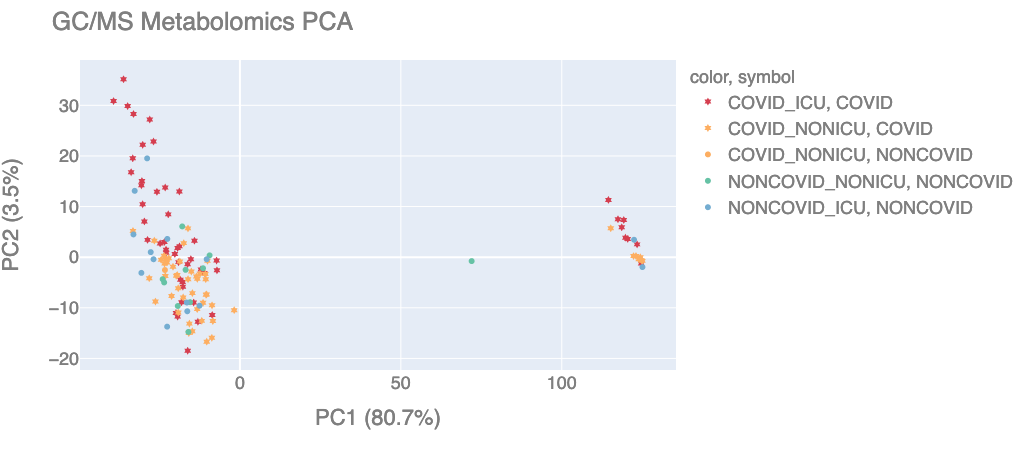

In [99]:
import plotly.express as px

df = pd.DataFrame({'x':PC1s, 'y':PC2s, 'sample_id':combined_df.index.tolist(), 'symbol':shape_list})

fig = px.scatter(df, x="x", y="y", hover_data=['sample_id'], color=color_list, color_discrete_map=color_dict,
                symbol=shape_list,
                symbol_map={"COVID":'hexagram', "NONCOVID":'circle'})

fig.update_layout(
    title="GC/MS Metabolomics PCA",
    xaxis_title='PC1 ({}%)'.format(round(100*pca.explained_variance_ratio_[0],1)),
    yaxis_title='PC2 ({}%)'.format(round(100*pca.explained_variance_ratio_[1],1)),
    font=dict(
        family="Helvetica",
        size=18,
        color="#7f7f7f")
    )
fig.show()

In [11]:
#connection.close()